<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000

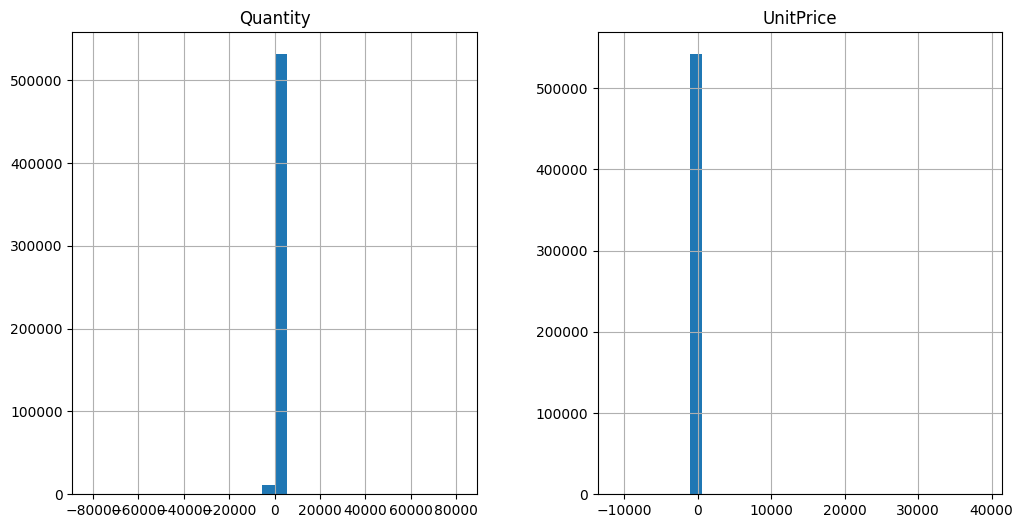

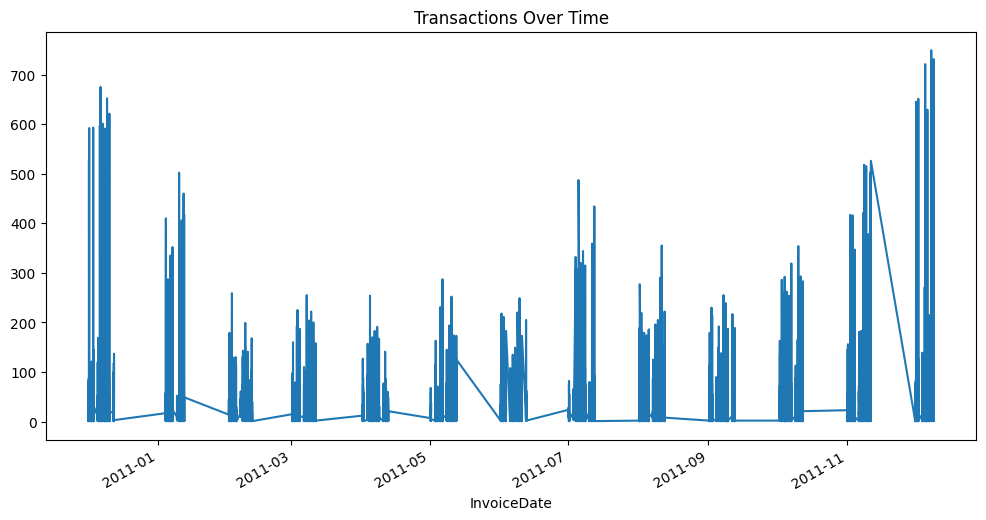

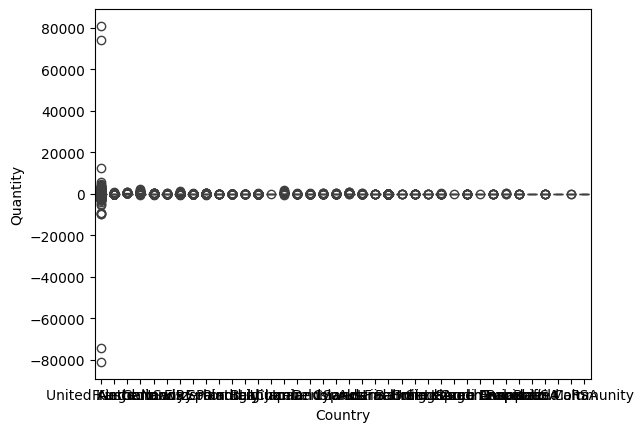

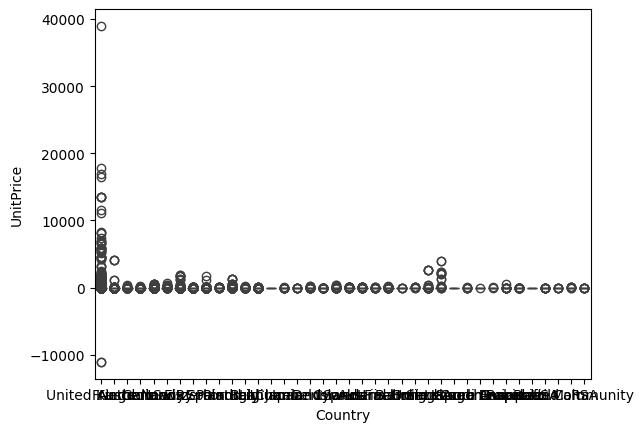

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the eCommerce dataset
df = pd.read_csv('eCommerce_Data.csv', encoding='ISO-8859-1')

# Check for basic information
print(df.info())

# Display summary statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Explore unique values in categorical columns
print(df['Country'].value_counts())
print(df['StockCode'].nunique())

# Check the distribution of numerical features
df[['Quantity', 'UnitPrice']].hist(bins=30, figsize=(12, 6))
plt.show()

# Check time-related patterns: Convert InvoiceDate to datetime if needed
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# Plot the number of transactions over time
plt.figure(figsize=(12, 6))
df.groupby('InvoiceDate').size().plot()
plt.title('Transactions Over Time')
plt.show()

# Boxplot to check for outliers in Quantity and UnitPrice
sns.boxplot(x='Country', y='Quantity', data=df)
plt.show()

sns.boxplot(x='Country', y='UnitPrice', data=df)
plt.show()


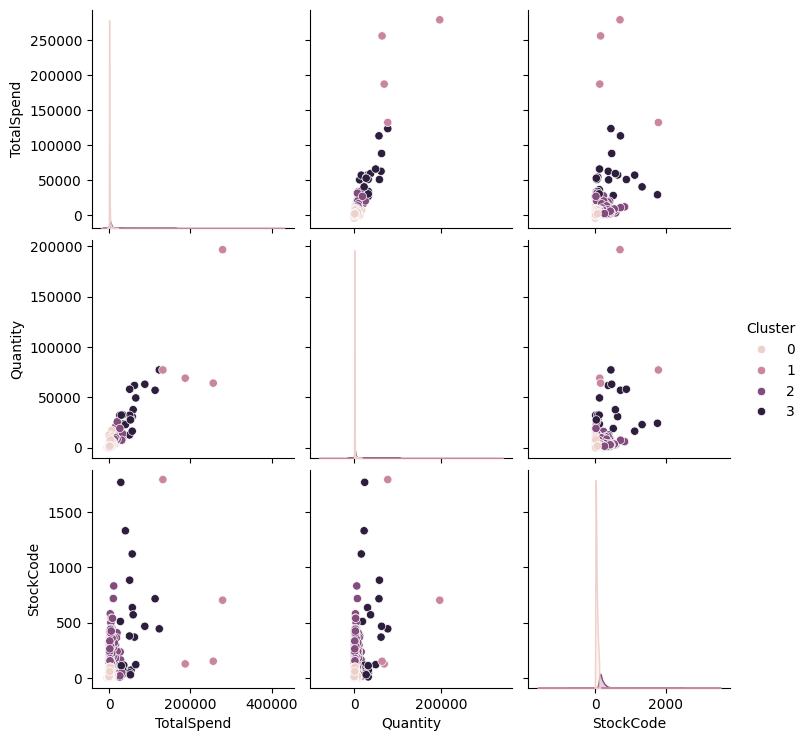

In [3]:
# Calculate TotalSpend for each transaction
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Group by CustomerID and aggregate the data
customer_data = df.groupby('CustomerID').agg({
    'TotalSpend': 'sum',
    'Quantity': 'sum',
    'StockCode': 'nunique'  # Number of unique products bought
}).reset_index()

# Normalize the data (important for clustering algorithms like KMeans)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalSpend', 'Quantity', 'StockCode']])

# KMeans Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)  # Choose number of clusters
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Visualize the clusters
sns.pairplot(customer_data, hue='Cluster', vars=['TotalSpend', 'Quantity', 'StockCode'])
plt.show()


In [ ]:
# Create TotalSpend feature
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Group by InvoiceNo to get transaction-level data
transaction_data = df.groupby('InvoiceNo').agg({
    'TotalSpend': 'sum',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
}).reset_index()

# Prepare features and target variable
X = transaction_data[['Quantity', 'UnitPrice']]
y = transaction_data['TotalSpend']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 218.77557872683633
MSE: 980361.5840576243
R2 Score: 0.852732492034084


In [7]:
# Define activity level based on total spending and frequency
customer_data['ActivityLevel'] = np.where(
    (customer_data['TotalSpend'] > customer_data['TotalSpend'].median()) & 
    (customer_data['Quantity'] > customer_data['Quantity'].median()), 'High', 'Low'
)

# Convert categorical variable to numerical labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
customer_data['ActivityLevel'] = encoder.fit_transform(customer_data['ActivityLevel'])

# Prepare features and target
X_class = customer_data[['TotalSpend', 'Quantity', 'StockCode']]
y_class = customer_data['ActivityLevel']

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train a classification model
from sklearn.ensemble import RandomForestClassifier
class_model = RandomForestClassifier(random_state=42)
class_model.fit(X_train_class, y_train_class)

# Predictions
y_class_pred = class_model.predict(X_test_class)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_test_class, y_class_pred))
print("Classification Report:")
print(classification_report(y_test_class, y_class_pred))


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      1.00      1.00       484

    accuracy                           1.00       875
   macro avg       1.00      1.00      1.00       875
weighted avg       1.00      1.00      1.00       875



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Prepare features (X) and target variable (y) for classification
X_class = customer_data[['TotalSpend', 'Quantity', 'StockCode']]
y_class = customer_data['ActivityLevel']

# Initialize the model
class_model = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_accuracy = cross_val_score(class_model, X_class, y_class, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cv_accuracy}")
print(f"Average Accuracy: {np.mean(cv_accuracy)}")
print(f"Standard Deviation of Accuracy: {np.std(cv_accuracy)}")

# You can also evaluate other metrics like precision, recall, or F1 score
cv_precision = cross_val_score(class_model, X_class, y_class, cv=5, scoring='precision')
cv_recall = cross_val_score(class_model, X_class, y_class, cv=5, scoring='recall')
cv_f1 = cross_val_score(class_model, X_class, y_class, cv=5, scoring='f1')

print(f"Cross-Validation Precision Scores: {cv_precision}")
print(f"Average Precision: {np.mean(cv_precision)}")

print(f"Cross-Validation Recall Scores: {cv_recall}")
print(f"Average Recall: {np.mean(cv_recall)}")

print(f"Cross-Validation F1 Scores: {cv_f1}")
print(f"Average F1 Score: {np.mean(cv_f1)}")


Cross-Validation Accuracy Scores: [1.         1.         0.99885584 1.         1.        ]
Average Accuracy: 0.9997711670480548
Standard Deviation of Accuracy: 0.0004576659038901809
Cross-Validation Precision Scores: [1.       1.       0.997921 1.       1.      ]
Average Precision: 0.9995841995841996
Cross-Validation Recall Scores: [1. 1. 1. 1. 1.]
Average Recall: 1.0
Cross-Validation F1 Scores: [1.         1.         0.99895942 1.         1.        ]
Average F1 Score: 0.9997918834547346
